### Лематизація за допомогою SpaCy

In [ ]:
!pip install -q spacy langdetect emoji
!python -m spacy download uk_core_news_sm
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 111.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 106.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the packa

In [ ]:
import spacy
import re
from langdetect import detect, LangDetectException
import emoji
import pandas as pd

In [ ]:
nlp_uk = spacy.load('uk_core_news_sm')
nlp_ru = spacy.load('ru_core_news_sm')
stop_words = nlp_uk.Defaults.stop_words.union(nlp_ru.Defaults.stop_words)

Завантаження та імпорт файлів "telegram_messages_1million_november.json" та "ru_dataset (for propaganda analysis).csv"

In [ ]:
!gdown 1NkgwCtfRs0Cawcrgnpw5gVCw9Zn1t24L

Downloading...
From: https://drive.google.com/uc?id=1NkgwCtfRs0Cawcrgnpw5gVCw9Zn1t24L
To: /content/ru_dataset (for propaganda analysis).csv
100% 11.7M/11.7M [00:00<00:00, 41.3MB/s]


In [ ]:
!gdown 1m1sKz6PJ-aTofB9YxzGJpaoOyZyIpob3

Downloading...
From (original): https://drive.google.com/uc?id=1m1sKz6PJ-aTofB9YxzGJpaoOyZyIpob3
From (redirected): https://drive.google.com/uc?id=1m1sKz6PJ-aTofB9YxzGJpaoOyZyIpob3&confirm=t&uuid=2971000a-4444-4a24-a493-d515edbed83d
To: /content/telegram_messages_1million_november.json
100% 748M/748M [00:08<00:00, 93.0MB/s]


In [ ]:
df_large_pd = pd.read_json("telegram_messages_1million_november.json")
df_large_pd = df_large_pd[['channel', 'date', 'text']].rename(columns={'channel': 'channel_name'})
df_large_pd['dataset_source'] = 'unlabeled'

df_propaganda_pd = pd.read_csv("ru_dataset (for propaganda analysis).csv")
df_propaganda_pd = df_propaganda_pd[['ChannelName', 'Date', 'PostText']].rename(
    columns={'ChannelName': 'channel_name', 'Date': 'date', 'PostText': 'text'}
)
df_propaganda_pd['dataset_source'] = 'propaganda'

Формування збалансованої підвибірки для рівномірної репрезентації усіх каналів з обох файлів

In [ ]:
def get_balanced_subset(df, posts_per_channel=500):
    return df.groupby('channel_name', group_keys=False).apply(
        lambda x: x.sample(min(len(x), posts_per_channel), random_state=42)
    )

In [ ]:
df_prop_sample = get_balanced_subset(df_propaganda_pd, posts_per_channel=250)
df_news_sample = get_balanced_subset(df_large_pd, posts_per_channel=800)
df_train_balanced = pd.concat([df_prop_sample, df_news_sample], ignore_index=True)

df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

Очищення та лематизація тексту, визначення показника суб'єктивності

In [ ]:
re_url = re.compile(r'https?://\S+|www\.\S+')
re_username = re.compile(r'@\w+')
re_numbers = re.compile(r'\d+')

In [ ]:
def deep_clean_text(text):
    if not isinstance(text, str) or len(text) < 5:
        return ''

    text = re_url.sub(' ', text)
    text = re_username.sub(' ', text)
    text = emoji.replace_emoji(text, replace=' ')
    text = re_numbers.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
def process_doc(doc, target_nlp):
    lemmas = []
    subj_count = 0
    total_tokens = 0
    for token in doc:
        if (token.is_alpha and
            not token.is_stop and
            len(token.text) > 2):
            total_tokens += 1
            if token.pos_ in ["ADJ", "ADV"]:
                subj_count += 1
            lemmas.append(token.lemma_.lower())

    subjectivity_score = subj_count / total_tokens if total_tokens > 0 else 0.0
    return lemmas, subjectivity_score

In [ ]:
def identify_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

In [ ]:
df_train_balanced['clean_text'] = df_train_balanced['text'].astype(str).apply(deep_clean_text)

In [ ]:
df_train_balanced['lang'] = df_train_balanced['clean_text'].apply(identify_language)

In [ ]:
df_uk = df_train_balanced[df_train_balanced['lang'] == 'uk'].copy()
df_ru = df_train_balanced[df_train_balanced['lang'] == 'ru'].copy()
df_other = df_train_balanced[~df_train_balanced['lang'].isin(['uk', 'ru'])].copy()

In [ ]:
uk_results = []
ru_results = []

In [ ]:
for doc in nlp_uk.pipe(df_uk['clean_text'], batch_size=2048, disable=["ner", "parser"]):
    uk_results.append(process_doc(doc, nlp_uk))
df_uk['lemmas'] = [r[0] for r in uk_results]
df_uk['subjectivity'] = [r[1] for r in uk_results]

In [ ]:
for doc in nlp_ru.pipe(df_ru['clean_text'], batch_size=2048, disable=["ner", "parser"]):
    ru_results.append(process_doc(doc, nlp_ru))
df_ru['lemmas'] = [r[0] for r in ru_results]
df_ru['subjectivity'] = [r[1] for r in ru_results]

In [ ]:
df_final = pd.concat([df_uk, df_ru], ignore_index=True)
df_final = df_final[df_final['lemmas'].apply(len) > 3]

In [ ]:
df_final

,channel_name,date,text,dataset_source,clean_text,lang,lemmas,subjectivity
0,censor_net,2021-09-24 07:22:58+00:00,🤦‍♂️ Закон про олігархів будуть переголосовува...,unlabeled,"Закон про олігархів будуть переголосовувати, в...",uk,"[закон, олігарх, переголосовувати, юридичний, ...",0.121212
1,suspilnenews,2023-10-21 10:17:29+00:00,Українська редакція журналу Vogue створила три...,unlabeled,Українська редакція журналу Vogue створила три...,uk,"[український, редакція, журнал, vogue, створит...",0.142857
2,operativnoZSU,2023-10-05 18:11:43+00:00,ІТ-Армія зупинила роботу найбільших аеропортів...,unlabeled,ІТ-Армія зупинила роботу найбільших аеропортів...,uk,"[армія, зупинити, робота, найбільший, аеропорт...",0.236842
3,verkhovnaradaukrainy,2023-12-18 13:05:21+00:00,❗️Комітет держвлади рекомендує прийняти за осн...,unlabeled,Комітет держвлади рекомендує прийняти за основ...,uk,"[комітет, держвлада, рекомендувати, прийняти, ...",0.271739
4,tgnews_ua,2024-05-02 19:08:01+00:00,На лівому березі Дніпра відбувається щось ціка...,unlabeled,На лівому березі Дніпра відбувається щось ціка...,uk,"[лівий, береза, дніпро, відбуватися, цікавий, ...",0.250000
...,...,...,...,...,...,...,...,...
18414,uniannet,2018-01-05 13:45:20+00:00,Так была ли атака повстанцев? Опубликовано вид...,unlabeled,Так была ли атака повстанцев? Опубликовано вид...,ru,"[атака, повстанец, опубликовать, видео, праздн...",0.111111
18415,Первый Харьковский,06/10/2024 10:03:11,Хлеб на Украине значительно подорожает\n\nЗаяв...,propaganda,Хлеб на Украине значительно подорожает Заявил ...,ru,"[хлеб, украина, значительно, подорожает, заяви...",0.200000
18416,nvua_official,2018-06-26 11:23:07+00:00,"Парадокс Ферми, уравнение Дрейка и при чем зде...",unlabeled,"Парадокс Ферми, уравнение Дрейка и при чем зде...",ru,"[парадокс, ферми, уравнение, дрейк, стивен, хо...",0.130435
18417,Мадуро - не дура,06/15/2024 14:37:01,Военный аналитик Алексей Леонков в программе «...,propaganda,Военный аналитик Алексей Леонков в программе «...,ru,"[военный, аналитик, алексей, леонков, программ...",0.431818


### Формування Bag of Words для застосування LDA та MinHashLSH

In [ ]:
df_final['corpus'] = df_final['lemmas'].apply(lambda x: ' '.join(x))

In [ ]:
MAX_FEATURES = 15000
MIN_DF = 5

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bow = CountVectorizer(max_features=MAX_FEATURES, min_df=MIN_DF)
X_bow_sparse = vectorizer_bow.fit_transform(df_final['corpus'])
feature_names = vectorizer_bow.get_feature_names_out()

In [ ]:
X_coo = X_bow_sparse.tocoo()
df_sparse_components = pd.DataFrame({
    'doc_index': X_coo.row,
    'feature_index': X_coo.col,
    'value': X_coo.data
})
df_final = df_final.reset_index().rename(columns={'index': 'doc_index'})
df_bow_final = df_sparse_components.merge(
    df_final[['doc_index', 'channel_name', 'dataset_source']],
    on='doc_index',
    how='left'
)

### Збереження на Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/MyDrive/Coursework_Data/'

import os
os.makedirs(DRIVE_PATH, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive змонтовано. Шлях для збереження: /content/gdrive/MyDrive/Coursework_Data/


In [ ]:
df_final['date_string'] = df_final['date'].astype(str)

In [ ]:
FILE_NAME = "lemmatized_data_100k.parquet"
FULL_SAVE_PATH = DRIVE_PATH + FILE_NAME
df_final[['doc_index', 'channel_name', 'dataset_source', 'date_string', 'text', 'lemmas', 'corpus', "subjectivity", "lang"]].to_parquet(FULL_SAVE_PATH)

In [ ]:
BOW_COMPONENTS_FILE = "bow_components.parquet"
FULL_BOW_PATH = DRIVE_PATH + BOW_COMPONENTS_FILE
df_bow_final.to_parquet(FULL_BOW_PATH, index=False)

In [ ]:
FEATURE_NAMES_FILE = "lda_feature_names.txt"
FULL_NAMES_PATH = DRIVE_PATH + FEATURE_NAMES_FILE
with open(FULL_NAMES_PATH, 'w', encoding='utf-8') as f:
    f.write('\n'.join(feature_names))

### Встановлення Spark та Spark NLP

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2025-12-22 08:46:05--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 3.86.22.73
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|3.86.22.73|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2025-12-22 08:46:05--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1483 (1.4K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.45K  --.-KB/s    in 0s      

2025-12-22 08:46:06 (30.5 MB/s) - written to stdout [1483/1483]

Installing PySpark

### Запуск Spark у режимі CPU

In [ ]:
import sparknlp
spark = sparknlp.start(params={"spark.ui.port": "4050"})

### Запуск Spark у режимі GPU

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Spark NLP GPU") \
    .master("local[*]") \
    .config("spark.driver.memory", "16G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", f"com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:6.2.3") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

### Запуск ngrok для Spark UI та Google Drive

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok, conf
conf.get_default().auth_token = ""
public_url = ngrok.connect(4050).public_url
print(f"Spark UI is accessible at: {public_url}")

Spark UI is accessible at: https://bulllike-viable-rosanna.ngrok-free.dev


In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, lit, when
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.clustering import LDA, KMeans
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, DoubleType
import json
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinHashLSH, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.window import Window
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/MyDrive/Coursework_Data/'

Mounted at /content/gdrive


### Сентиментальний аналіз за допомогою xlmroberta_classifier_verdict

In [ ]:
FILE_NAME = "lemmatized_data_100k.parquet"
FULL_SAVE_PATH = DRIVE_PATH + FILE_NAME

df_clean = spark.read.parquet(FULL_SAVE_PATH)

In [ ]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols("document") \
    .setOutputCol("token")

seq_classifier = XlmRoBertaForSequenceClassification.pretrained("xlmroberta_classifier_verdict","xx") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("class")

finisher = Finisher() \
    .setInputCols(["class"]) \
    .setOutputCols(["sentiment_result"])

sentimental_pipeline = Pipeline(stages=[documentAssembler, tokenizer, seq_classifier, finisher])

xlmroberta_classifier_verdict download started this may take some time.
Approximate size to download 936.6 MB
[OK!]


In [ ]:
model_sentimental = sentimental_pipeline.fit(df_clean)
df_sentimental = model_sentimental.transform(df_clean)
df_sentimental = df_sentimental.withColumn("sentiment_label", F.element_at(col("sentiment_result"), 1))

In [ ]:
df_final = df_sentimental.withColumn("sentiment_label", F.element_at(col("sentiment_result"), 1))
cols_to_save = ['doc_index', 'channel_name', 'dataset_source', 'date_string', 'text', 'lemmas', 'corpus', "subjectivity", "lang", 'sentiment_label', 'sentiment_result']
SENTIMENT_RESULTS_FILE = DRIVE_PATH + "sentiment_results_100k.parquet"
df_final.select(*cols_to_save).write.mode("overwrite").parquet(SENTIMENT_RESULTS_FILE)


### Формування тем за допомогою LDA

In [ ]:
DRIVE_PATH = '/content/gdrive/MyDrive/Coursework_Data/'
SENTIMENT_RESULTS_FILE = DRIVE_PATH + "sentiment_results_100k.parquet"
BOW_COMPONENTS_FILE = DRIVE_PATH + "bow_components.parquet"
FEATURE_NAMES_FILE = DRIVE_PATH + "lda_feature_names.txt"
LDA_TOPICS_FILE = DRIVE_PATH + "lda_topic_keywords.json"
LDA_RESULTS_FILE = DRIVE_PATH + "lda_results_100k.parquet"

In [ ]:
with open(FEATURE_NAMES_FILE, 'r', encoding='utf-8') as f:
    feature_names = [line.strip() for line in f]

In [ ]:
vector_size = len(feature_names)

Розпакування векторів Bag of Words

In [ ]:
df_bow_components = spark.read.parquet(BOW_COMPONENTS_FILE)

In [ ]:
df_paired = df_bow_components.withColumn(
    "pair",
    F.struct(F.col("feature_index"), F.col("value"))
)

df_grouped_pairs = df_paired.groupBy("doc_index").agg(
    F.collect_list("pair").alias("pairs")
)

df_sorted_pairs = df_grouped_pairs.withColumn(
    "sorted_pairs",
    F.array_sort(F.col("pairs"))
)

df_grouped_final = df_sorted_pairs.withColumn(
    "indices",
    F.col("sorted_pairs.feature_index")
).withColumn(
    "values",
    F.col("sorted_pairs.value")
).select("doc_index", "indices", "values")

In [ ]:
from pyspark.ml.linalg import VectorUDT, Vectors
@F.udf(VectorUDT())
def create_sparse_vector(indices, values):
    if not indices:
        return Vectors.sparse(vector_size, [], [])

    return Vectors.sparse(vector_size, indices, values)

df_features_only = df_grouped_final.withColumn(
    "features",
    create_sparse_vector(F.col("indices"), F.col("values"))
).select("doc_index", "features")

In [ ]:
df_sentiment = spark.read.parquet(SENTIMENT_RESULTS_FILE)

In [ ]:
df_analysis = df_features_only.join(
    df_sentiment,
    on="doc_index",
    how="inner"
)

Запуск алгоритму LDA

In [ ]:
num_topics = 20
lda = LDA(k=num_topics, maxIter=20, seed=42, featuresCol="features")
lda_model = lda.fit(df_analysis)
df_with_topics = lda_model.transform(df_analysis)

In [ ]:
get_max_topic = F.udf(lambda v: int(v.argmax()), IntegerType())
df_final_analysis = df_with_topics.withColumn("main_topic", get_max_topic(F.col("topicDistribution")))

Збереження результатів запуску алгоритму

In [ ]:
topics = lda_model.describeTopics(10)
topics_data = []

for row in topics.collect():
    topic_id = row.topic
    terms = [feature_names[idx] for idx in row.termIndices]

    topics_data.append({
        "topic_id": topic_id,
        "keywords": terms,
        "weights": row.termWeights
    })
    print(f"Topic {topic_id}: {terms}")

with open(LDA_TOPICS_FILE, 'w', encoding='utf-8') as f:
    json.dump(topics_data, f, ensure_ascii=False, indent=4)

Topic 0: ['военный', 'гавана', 'казань', 'атомный', 'проект', 'подводный', 'куба', 'россия', 'порт', 'корабль']
Topic 1: ['территория', 'область', 'бпла', 'минобороны', 'уничтожить', 'дежурный', 'пво', 'пресечь', 'мск', 'террористический']
Topic 2: ['вектор', 'військовий', 'україна', 'місто', 'новина', 'служба', 'родный', 'правопорядок', 'пост', 'здание']
Topic 3: ['просмотр', 'выпуск', 'посвящён', 'город', 'рассказывать', 'митрополит', 'фильм', 'христов', 'игнатий', 'весенний']
Topic 4: ['всу', 'область', 'район', 'противник', 'удар', 'направление', 'ракета', 'пункт', 'войско', 'дрон']
Topic 5: ['израиль', 'украина', 'военный', 'иран', 'заявить', 'израильский', 'учение', 'газа', 'сша', 'министр']
Topic 6: ['україна', 'росія', 'facebook', 'український', 'країна', 'президент', 'сша', 'російський', 'підписатися', 'війна']
Topic 7: ['мопед', 'курс', 'подлетать', 'громковато', 'дана', 'сторона', 'киев', 'закон', 'борисполь', 'львов']
Topic 8: ['россия', 'украина', 'год', 'человек', 'страна

In [ ]:
df_final_analysis.write.mode("overwrite").parquet(LDA_RESULTS_FILE)

### Обчислення значень TTR та кількості займенників

In [ ]:
LDA_RESULTS_FILE = DRIVE_PATH + "lda_results_100k.parquet"
df_analysis = spark.read.parquet(LDA_RESULTS_FILE)

TTR

In [ ]:
df_analysis = df_analysis.withColumn(
    "ttr",
    F.when(F.size(F.col("lemmas")) > 0,
           F.size(F.array_distinct(F.col("lemmas"))) / F.size(F.col("lemmas"))
          ).otherwise(0.0)
)

We/They count

In [ ]:
group_us_lemmas = {
    # Українська (UA)
    'я', 'мене', 'мені', 'мною', 'мій', 'мого', 'моєму', 'моїм', 'моя', 'моє', 'мої', 'моїх',
    'ми', 'нас', 'нам', 'нами', 'наш', 'нашого', 'нашому', 'нашим', 'наша', 'наше', 'наші', 'наших',
    'свій', 'свого', 'своєму', 'своїм', 'своя', 'своє', 'свої', 'своїх',

    # російська (ru)
    'я', 'меня', 'мне', 'мной', 'мною', 'мой', 'моего', 'моему', 'моим', 'моя', 'мое', 'моё', 'мои', 'моих',
    'мы', 'нас', 'нам', 'нами', 'наш', 'нашего', 'нашему', 'нашим', 'наша', 'наше', 'наши', 'наших',
    'свой', 'своего', 'своему', 'своим', 'своя', 'свое', 'своё', 'свои', 'своих'
}

group_them_lemmas = {
    # Українська (UA)
    'ти', 'тебе', 'тобі', 'тобою', 'твій', 'твого', 'твоєму', 'твоїм', 'твоя', 'твоє', 'твої', 'твоїх',
    'ви', 'вас', 'вам', 'вами', 'ваш', 'вашого', 'вашому', 'вашим', 'ваша', 'ваше', 'ваші', 'ваших',
    'вони', 'них', 'їх', 'їм', 'ними', 'їхній', 'їхнього', 'їхньому', 'їхнім', 'їхня', 'їхнє', 'їхні',

    # російська (ru)
    'ты', 'тебя', 'тебе', 'тобой', 'тобою', 'твой', 'твоего', 'твоему', 'твоим', 'твоя', 'твое', 'твоё', 'твои', 'твоих',
    'вы', 'вас', 'вам', 'вами', 'ваш', 'вашего', 'вашему', 'вашим', 'шаша', 'ваше', 'ваши', 'ваших',
    'они', 'них', 'их', 'им', 'ими', 'ихний', 'ихнего', 'ихнему', 'ихним', 'ихняя', 'ихнее'
}

bc_us = spark.sparkContext.broadcast(group_us_lemmas)
bc_them = spark.sparkContext.broadcast(group_them_lemmas)

def calc_pronouns(text):
    if not text: return (0, 0)

    words = re.findall(r'\w+', text.lower())
    total_words = len(words)

    if total_words == 0: return (0, 0)

    us_count = 0
    them_count = 0

    us_set = bc_us.value
    them_set = bc_them.value

    for w in words:
        if w in us_set:
            us_count += 1
        elif w in them_set:
            them_count += 1

    return (float(us_count), float(them_count))

pronouns_schema = StructType([
    StructField("us_rate", DoubleType(), False),
    StructField("them_rate", DoubleType(), False)
])
pronouns_udf = F.udf(calc_pronouns, pronouns_schema)

In [ ]:
df_analysis = df_analysis.withColumn("lemma_count", F.size(F.col("lemmas")))

In [ ]:
df_analysis = df_analysis.withColumn("pronouns_struct", pronouns_udf(F.col("text"))) \
    .withColumn("pronoun_us", F.col("pronouns_struct.us_rate") / F.col("lemma_count")) \
    .withColumn("pronoun_them", F.col("pronouns_struct.them_rate") / F.col("lemma_count")) \
    .drop("pronouns_struct")

In [ ]:
TTR_RESULTS_FILE = DRIVE_PATH + "ttr_results_100k.parquet"
df_analysis.write.mode("overwrite").parquet(TTR_RESULTS_FILE)

### (OUT OF RAM) Визначення частин мови за допомогою BERT моделей

In [ ]:
pipeline_lang = PretrainedPipeline("detect_language_220", lang="xx")
df_analysis = pipeline_lang.transform(df_analysis)

In [ ]:
df_analysis = df_analysis.withColumn("lang_code", F.element_at(F.col("language.result"), 1))

df_uk = df_analysis.filter(F.col("lang_code") == "uk")
df_ru = df_analysis.filter(F.col("lang_code") == "ru")

In [ ]:
def get_pos_pipeline(model_name, lang_code):
    document = DocumentAssembler().setInputCol("text").setOutputCol("document")

    # BERT вимагає токенів
    tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

    # BERT POS Model
    # Використовуємо BertForTokenClassification для POS тегів
    bert_pos = BertForTokenClassification.pretrained(model_name, lang_code) \
        .setInputCols(["document", "token"]) \
        .setOutputCol("pos")

    finisher = Finisher().setInputCols(["pos"]).setOutputCols(["pos_tags"])

    return Pipeline(stages=[document, tokenizer, bert_pos, finisher])


In [ ]:
pipeline_uk = get_pos_pipeline("bert_pos_bert_base_slavic_cyrillic_upos", "uk")
model_uk = pipeline_uk.fit(df_uk)
df_uk_tagged = model_uk.transform(df_uk)

bert_pos_bert_base_slavic_cyrillic_upos download started this may take some time.
Approximate size to download 637.2 MB
[OK!]


In [ ]:
pipeline_ru = get_pos_pipeline("bert_pos_bert_base_russian_upos", "ru")
model_ru = pipeline_ru.fit(df_ru)
df_ru_tagged = model_ru.transform(df_ru)

bert_pos_bert_base_russian_upos download started this may take some time.
Approximate size to download 634.3 MB
[OK!]


In [ ]:
df_analysis = df_uk_tagged.unionByName(df_ru_tagged)

In [ ]:
df_analysis.select("pos_tags").show(5, truncate=False)

In [ ]:
def calc_subjectivity(tags):
    if not tags: return 0.0

    count = 0
    for tag in tags:
        if "ADJ" in tag or "ADV" in tag:
            count += 1

    return count / len(tags)

subjectivity_udf = F.udf(calc_subjectivity, DoubleType())

In [ ]:
df_analysis = df_analysis.withColumn("subjectivity", subjectivity_udf(F.col("pos_tags")))

In [ ]:
ANALYSIS_RESULTS_FILE = DRIVE_PATH + "analysis_results_100k.parquet"
df_final_analysis.write.mode("overwrite").parquet(ANALYSIS_RESULTS_FILE)

### Пошук кількості дублікатів за допомогою MinHashLSH

In [ ]:
TTR_RESULTS_FILE = DRIVE_PATH + "ttr_results_100k.parquet"
df_analysis = spark.read.parquet(TTR_RESULTS_FILE)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)

In [ ]:
model_lsh = mh.fit(df_analysis)
df_hashed = model_lsh.transform(df_analysis)

In [ ]:
threshold = 0.1
df_matches = model_lsh.approxSimilarityJoin(
    df_hashed, df_hashed, threshold, distCol="JaccardDistance"
)

In [ ]:
duplicate_features = df_matches.groupBy(col("datasetA.doc_index").alias("doc_index")) \
    .agg(F.count("*").alias("duplicate_count"))

In [ ]:
df_with_cp_feature = df_analysis.join(duplicate_features, on="doc_index", how="left")

In [ ]:
df_with_cp_feature = df_with_cp_feature.fillna({"duplicate_count": 1})

In [ ]:
DC_RESULTS_FILE = DRIVE_PATH + "duplicate_results_100k.parquet"
df_with_cp_feature.write.mode("overwrite").parquet(DC_RESULTS_FILE)


### Застосування моделі Random Forest для класифікації

In [ ]:
DC_RESULTS_FILE = DRIVE_PATH + "duplicate_results_100k.parquet"

In [ ]:
df_analysis = spark.read.parquet(DC_RESULTS_FILE)

In [ ]:
SMOOTHING = 10.0

df_labeled = df_analysis.withColumn(
    "label",
    F.when(F.col("dataset_source") == "propaganda", 1.0).otherwise(0.0)
).withColumn(
    # Відновлюємо кількість (Rate * Count) і ділимо на згладжений знаменник
    "p_us_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_us") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_them_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_them") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_subj_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("subjectivity") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
)

In [ ]:
prop_count = df_labeled.filter(F.col("label") == 1.0).count()
non_prop_count = df_labeled.filter(F.col("label") == 0.0).count()
fraction = prop_count / non_prop_count if non_prop_count > prop_count else 1.0
df_balanced = df_labeled.sampleBy("label", fractions={1.0: 1.0, 0.0: fraction}, seed=42)

Результати LDA було виключено для зменшення кореляції з мовою публікації

In [ ]:
sentiment_indexer = StringIndexer(inputCol="sentiment_label", outputCol="sentiment_index").setHandleInvalid("keep")
#topic_indexer = StringIndexer(inputCol="main_topic", outputCol="topic_index").setHandleInvalid("keep")

In [ ]:
assembler = VectorAssembler(
    inputCols=[
        "ttr",
        "p_us_norm", "p_them_norm", "p_subj_norm", "duplicate_count",
        "sentiment_index"#, "topic_index", "topicDistribution", "features"
    ],
    outputCol="all_features"
)

In [ ]:
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="all_features",
    seed=42,
    numTrees=200,
    maxBins=64,
    subsamplingRate=0.8
)

In [ ]:
pipeline = Pipeline(stages=[sentiment_indexer, assembler, rf]) # topic_indexer,

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.featureSubsetStrategy, ["sqrt", "log2"]) \
    .build()

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

In [ ]:
cvModel = cv.fit(df_balanced)

In [ ]:
predictions = cvModel.transform(df_balanced)

In [ ]:
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.7104


In [ ]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6453
F1-Score: 0.6365


In [ ]:
best_rf = cvModel.bestModel.stages[-1]
importances = best_rf.featureImportances

In [ ]:
df_full_prepared = df_analysis.withColumn(
    # Відновлюємо кількість (Rate * Count) і ділимо на згладжений знаменник
    "p_us_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_us") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_them_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_them") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_subj_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("subjectivity") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
)

In [ ]:
df_scored = cvModel.transform(df_full_prepared)

In [ ]:
OUTPUT_SCORED_FILE = DRIVE_PATH + "scored_results_100k.parquet"

In [ ]:
df_scored.write.mode("overwrite").parquet(OUTPUT_SCORED_FILE)

### Застосування моделі GBTClassifier для класифікації

In [ ]:
DC_RESULTS_FILE = DRIVE_PATH + "duplicate_results_100k.parquet"

In [ ]:
df_analysis = spark.read.parquet(DC_RESULTS_FILE)

In [ ]:
SMOOTHING = 10.0

df_labeled = df_analysis.withColumn(
    "label",
    F.when(F.col("dataset_source") == "propaganda", 1.0).otherwise(0.0)
).withColumn(
    # Відновлюємо кількість (Rate * Count) і ділимо на згладжений знаменник
    "p_us_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_us") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_them_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_them") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_subj_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("subjectivity") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
)

In [ ]:
prop_count = df_labeled.filter(F.col("label") == 1.0).count()
non_prop_count = df_labeled.filter(F.col("label") == 0.0).count()
fraction = prop_count / non_prop_count if non_prop_count > prop_count else 1.0
df_balanced = df_labeled.sampleBy("label", fractions={1.0: 1.0, 0.0: fraction}, seed=42)

Результати LDA було виключено для зменшення кореляції з мовою публікації

In [ ]:
sentiment_indexer = StringIndexer(inputCol="sentiment_label", outputCol="sentiment_index").setHandleInvalid("keep")
#topic_indexer = StringIndexer(inputCol="main_topic", outputCol="topic_index").setHandleInvalid("keep")

In [ ]:
assembler = VectorAssembler(
    inputCols=[
        "ttr",
        "p_us_norm", "p_them_norm", "p_subj_norm", "duplicate_count",
        "sentiment_index"#, "topic_index", "topicDistribution", "features"
    ],
    outputCol="all_features"
)

In [ ]:
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="all_features",
    seed=42,
    subsamplingRate=0.7,
    maxBins=128
)

In [ ]:
pipeline = Pipeline(stages=[sentiment_indexer, assembler, gbt]) # topic_indexer,

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [50, 100]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

In [ ]:
cvModel = cv.fit(df_balanced)

In [ ]:
predictions = cvModel.transform(df_balanced)

In [ ]:
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.6450


In [ ]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6017
F1-Score: 0.5947


In [ ]:
best_gbt = cvModel.bestModel.stages[-1]
importances = best_gbt.featureImportances

In [ ]:
importances

SparseVector(6, {0: 0.1787, 1: 0.1464, 2: 0.1498, 3: 0.271, 4: 0.1977, 5: 0.0564})

In [ ]:
df_full_prepared = df_analysis.withColumn(
    # Відновлюємо кількість (Rate * Count) і ділимо на згладжений знаменник
    "p_us_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_us") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_them_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("pronoun_them") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
).withColumn(
    "p_subj_norm",
    F.when(F.col("lemma_count") > 0,
           (F.col("subjectivity") * F.col("lemma_count")) / (F.col("lemma_count") + SMOOTHING)
          ).otherwise(0.0)
)

In [ ]:
df_scored = cvModel.transform(df_full_prepared)

In [ ]:
OUTPUT_SCORED_FILE = DRIVE_PATH + "scored_results_100k.parquet"

In [ ]:
df_scored.write.mode("overwrite").parquet(OUTPUT_SCORED_FILE)

### Збереження загальних та агрегованих результатів у CSV файл

In [ ]:
extract_prob_udf = F.udf(lambda v: float(v[1]) if v else 0.0, DoubleType())

df_csv_detailed = df_scored.withColumn("prop_probability", extract_prob_udf(F.col("probability"))) \
    .select(
        "doc_index",
        "channel_name",
        "dataset_source",
        "lang",
        "sentiment_label",
        "main_topic",
        "ttr",
        "pronoun_us",
        "pronoun_them",
        "subjectivity",
        "p_us_norm",
        "p_them_norm",
        "p_subj_norm",
        "lemma_count",
        "duplicate_count",
        F.col("prop_probability").alias("propaganda_probability"),
        "prediction"
    )

In [ ]:
pdf_detailed = df_csv_detailed.toPandas()
pdf_detailed.to_csv(DRIVE_PATH + "detailed_posts_analytics.csv", index=False)

In [ ]:
topic_window = Window.partitionBy("channel_name").orderBy(F.col("topic_count").desc())
df_top_topics = df_scored.groupBy("channel_name", "main_topic") \
    .count().withColumnRenamed("count", "topic_count") \
    .withColumn("rank", F.row_number().over(topic_window)) \
    .filter(F.col("rank") == 1) \
    .select("channel_name", F.col("main_topic").alias("most_frequent_topic"))

In [ ]:
lang_window = Window.partitionBy("channel_name").orderBy(F.col("lang_count").desc())
df_top_lang = df_scored.groupBy("channel_name", "lang") \
    .count().withColumnRenamed("count", "lang_count") \
    .withColumn("rank", F.row_number().over(lang_window)) \
    .filter(F.col("rank") == 1) \
    .select("channel_name", F.col("lang").alias("dominant_language"))

In [ ]:
df_channel_agg = df_scored.withColumn(
    "is_misinfo", F.when(F.col("sentiment_label") == "misinformation", 1).otherwise(0)
).groupBy("channel_name").agg(
    F.first("dataset_source").alias("source_type"),
    F.avg("is_misinfo").alias("misinformation_rate"),
    F.avg("ttr").alias("avg_ttr"),
    F.avg("p_us_norm").alias("avg_balanced_pronoun_us"),
    F.avg("p_them_norm").alias("avg_balanced_pronoun_them"),
    F.avg("p_subj_norm").alias("avg_balanced_subjectivity"),
    F.count("*").alias("post_count"),
    F.sum("duplicate_count").alias("total_duplicates_sum"),
    F.avg("prediction").alias("propaganda_percentage")
)

In [ ]:
df_final_agg = df_channel_agg.join(df_top_topics, on="channel_name", how="left").join(df_top_lang, on="channel_name", how="left")

In [ ]:
pdf_agg = df_final_agg.toPandas()
pdf_agg.to_csv(DRIVE_PATH + "channel_summary_analytics.csv", index=False)

### Матриця помилок

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/MyDrive/Coursework_Data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


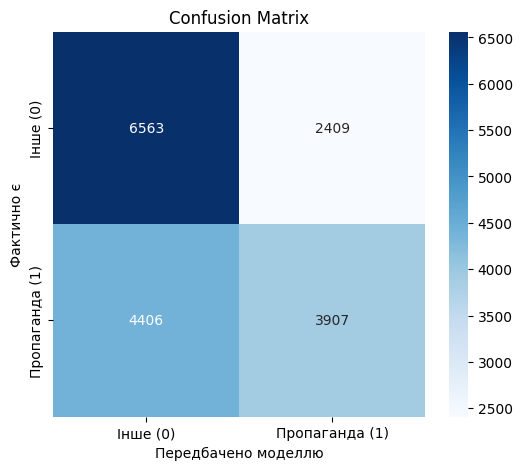

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

df = pd.read_csv(DRIVE_PATH + 'detailed_posts_analytics.csv')
df['y_true'] = df['dataset_source'].apply(lambda x: 1.0 if x == 'propaganda' else 0.0)

y_true = df['y_true']
y_pred = df['prediction']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Інше (0)', 'Пропаганда (1)'],
            yticklabels=['Інше (0)', 'Пропаганда (1)'])
plt.xlabel('Передбачено моделлю')
plt.ylabel('Фактично є')
plt.title('Confusion Matrix')
plt.show()